1. introduction

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #이미지 데이터를 다루기 위한 도구
import seaborn as sns

%matplotlib inline #노트북 환경에서 그래프나 이미지와 같은 시각화 결과물을 직접 노트북에서 보여줌(매작 커맨드)

np.random.seed(2)#실험의 재현성을 보장하기 위해

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools #반복 가능한 데이터 구조를 효과적으로 처리(여러 함수와 반복자)

from keras.utils.np_utils import to_categorical #정수 레이블을 원-핫 인코딩 형태로 변환
from keras.models import Sequential #레이어를 순차적으로 쌓아 모델을 구성
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D #다양한 레이어 타입
#Dense: 완전 열결 레이어, Dropout: 과적합 방지, Flatten: 다차원-> 1차원 평탄화, Conv2D: 2D 합성곱레이어, 이미지 처리
#MaxPool2D: 2D최대 풀링 레이어, 합성곱 레이어의 출력 크기 줄임
from keras.optimizers import RMSprop #신경망 학습
from keras.preprocessing.image import ImageDataGenerator #이미지 배치를 생성. 데이터를 증강하여 과적합 방지
from keras.callbacks import ReduceLROnPlateau #학습률을 자동으로 조정하는 콜백,
#특정 조건 도달하면 학습률을 줄여 모델의 학습을 개선

sns.set(style="white", context="notebook", palette="deep") #seaborn에 관한 시각적 요소 설정

2. Data prepartion

2-1Load data

In [26]:
train = pd.read_csv("train.csv")#같은 경로의 파일이면 /없이 바로 파일 값 넣기
test = pd.read_csv("test.csv")  
#pixerl값이 0으로 되어있는 데이터들이 쭉 있음

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

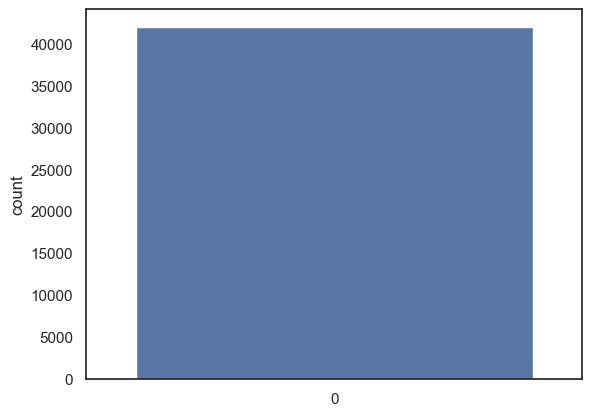

In [27]:
Y_train = train["label"]

#Drop "label" column
X_train = train.drop(labels = ["label"], axis = 1)

#free some space

del train #pd.read로 불러온 데이터는 삭제

g = sns.countplot(Y_train)
#countplot함수는 각 범주형 레이블의 개수를 막대 그래프 형식으로 표시, 각 데이터의 개수를 쉽게 시각화
Y_train.value_counts() 




그래프 오류 ????

2-2 Check for null and missing values
##아래 코드를 통해서 null값이 없는것을 확인

In [28]:
X_train.isnull().any().describe()
#any()는 주어진 축에 대해 하나 이상의 요소가 true인지 검사. 데이터 열에 대해서 검사
#isnull 통해서 false 값 가져옴
#describe -> count 784 ,총 784개의 열이 있음 / top: 제일 많은 값은 FALSE / freq: FALSE값이 784번 나옴 / unique: 특성 (1개만 있음 false)
#즉, 이 데이터는 784개의 열을 가지고 있으며 unique(값은 하나로만 되어 있음) -> null값이 없으니 모든 값이 false로 나옴

##isnull이 true값 -> any 감지 -> describe(보여줘라) -> null값이 없음


count       784
unique        1
top       False
freq        784
dtype: object

In [29]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

2-3 Normalization

#그레이스케일 정규화 과정
1. 조명 차이 감소: 그레이스케일 정규화를 통해 픽셀 값의 범위를 [0,1]로 제한함으로써 조명 차이 줄일 수 있음
2. 픽셀 값을 [0,1] 범위로 정규화함으로써, 신경망은 더 빠르게 수렴
3. 수치 안전성: 픽셀 값을 작은 범위로 제한, 수치 안정성 향상
##255는 8비트 그레이스케일 이미지에서 픽셀값의 최대값
->이 작업을 통해 모델의 학습 성능과 수렴 속도를 향상

In [30]:
X_train = X_train / 255.0
test = test / 255.0

2-3 Reshape
1차원 벡터로 저장된 이미지 데이터를 3차원 행렬로 변환. 
각 이미지는 28*28 픽셀의 크기를 가지며, 그레이스케일 이미지이므로 채널수는 1
*채널수: 이미지의 색상 정보를 나타내는 차원의 수
1. 그레이스케일 이미지(1채널): 흑백 이미지[0,255]
2. RGB이미지(3채널): RGB (255,255,255)...
3. RGBA 이미지(4채널): RGB + A(알파) 투명도

**-1은 차원을 자동으로 계산

데이터는 각 이미지가 784개의 연속된 픽셀 값으로 표현 (28*28 = 784)이므로 28 *28로 변환
1. 원본형태 복원: 784개의 연속된 픽셀 값으로 표현된 데이터를 28*28형태로 재구성, 원래 이미지로 복원
2. 합성곱 신경망: CNN은 2D이므로


In [ ]:
#Reshape image in 3 dimensions (height = 28px, width = 28pxm, canal = 1)
X_train = X_train.values.reshape(-1, 28, 28,1) 
test = test.values.reshape(-1, 28, 28,1)
#각 이미지를 28*28 크기의 그레이스케일 이미지로 변환 (마지막 1은 채널수)

#원래 이미지 데이터는 784개의 연속된 픽셀 값으로 표현 -> 28 * 28 1차원 크기 784개
#3차원 배열로 변경 / 크기: 28*28*1 (높이, 너비, 채널)
'''
(-1, 28, 28, 1)
-1 -> 이미지의 개수 자동 저장
28 -> 이미지 높이
28 -> 이미지의 너비
1 -> 채널 수
'''



'\n(-1, 28, 28, 1)\n-1 -> 이미지의 개수 자동 저장\n28 -> 이미지 높이\n28 -> 이미지의 너비\n1 -> 채널 수\n'

##2.5 Label encoding

to_categorical 함수는 keras를 활용하여 정수 레이블을 원-핫 인코딩 벡터로 변환
num_classes = 10은 0부터 9까지의 10개의 클래스를 가지고 있어서 원 핫 인코딩 과정 진행

In [32]:
#Encode labels to one hot vecetors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

##2-6 Split training and valdiation set

In [33]:
#Set the random seed
random_seed = 2 #재현하기 위해

In [34]:
#split the train and the validation se for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = random_seed, stratify=Y_train) #stratify대이터 분할 클래스 비율 유지
#X_train값 순서대로 -> Y_train 값 (인코딩 한 결과값)으로 훈련 진행

#stratify 기능 추가할 수 있음
stratify: 데이터를 분할할 때 클래스의 비율을 유지하는데 사용. 


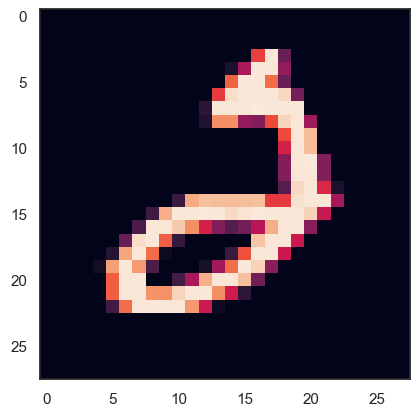

In [35]:
#somw examples
g = plt.imshow(X_train[0][:,:,0])
#x_train[0] ->이 배열의 첫번째 이미지. 28*28*1크기로 되어있음(높이28,너비28,1채널)
#[:,:,0] ->3차원 배열에서 특정 부분을 선택. [모든 높이, 모든 너비, 0그레이스케일]
#즉, 첫 번째 이미지의 모든 픽셀 값을 선택하되, 채널의 차원을 제거하여 28*28 크기의 2차원 배열

3.CNN <br>
3.1 Define the model

##keras룰 사용하여 cnn모델을 생성

In [36]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential() #Sequential() "API"를 사용하여 모델을 초기화. 이를 통해 레이어를 순차적으로 쌓을 수 있음

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

'''
첫 번째 두 개의 Conv2D 레이어는 각각 32개의 필터와 5x5 크기의 커널을 가지고 있습니다.
padding='Same'은 입력과 출력의 크기를 동일하게 유지합니다.
activation: 활성화 함수 각 뉴런이 출력하는 값을 결정하는 함수
relu: 활성화 함수. 0보다 크면 그 값을 그대로 출력, 0보다 작으면 0을 출력
MaxPool2D 레이어로 특징을 다운샘플링합니다.
Dropout 레이어로 25%의 뉴런을 무작위로 끕니다. (과적합 방지, 학습과정에서 일부 뉴런을 무작위로 끔)
학습과정의 각 단계에서 25%의 뉴런을 무작위로 끔
'''

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

'''
다음 두 개의 Conv2D 레이어는 각각 64개의 필터와 3x3 크기의 커널을 가지고 있습니다.
strides=(2,2) 파라미터로 풀링 레이어의 스트라이드를 설정합니다.
'''

#convolutional블록이 각각 두 개씩 있는 이유는 네트워크의 표현 능력을 증가시키기 위해서.
#여러개의 convolutional 레이어를 쌓아올림으로써, 네트워크는 더 복잡하고 고차원적인 특징을 학습할 수 있음
#레이어를 깊게 쌓을 수록 더 추상적이고 고차원적인 특징을 학습
"""
첫 번째 Convolutional 레이어:
일반적으로 첫 번째 convolutional 레이어는 이미지의 기본적인 특징을 캡처합니다. 
예를 들어, 엣지, 색상, 그래디언트 등의 저수준 특징을 검출합니다.
두 번째 Convolutional 레이어:
두 번째 레이어는 첫 번째 레이어의 출력을 입력으로 받아, 더 높은 수준의 특징을 학습합니다.
이러한 특징은 각종 패턴, 텍스처 등을 포함할 수 있습니다.

Pooling 레이어와 Dropout:
각 convolutional 블록 뒤에는 pooling 레이어와 dropout 레이어가 있습니다.
이 레이어들은 네트워크의 과적합을 방지하고, 계산 효율성을 향상시킵니다.

##하지만 너무 많은 레이어를 쌓는 것도 문제 -> 과적합, 증가하는 계산 비용, 훈련 시간의 증가
"""

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
#softmax -> 모든 클래스의 확률의 합은 1
"""
Flatten 레이어:

Flatten 레이어는 이전 레이어의 다차원 출력을 1차원 벡터로 변환합니다. 
이는 완전 연결 레이어에 대한 입력을 준비하기 위한 과정입니다. 
예를 들어, 2차원 특징 맵을 1차원 벡터로 펼칩니다.

Dense: 신경망에서 모든 뉴런이 이전 레이어의 모든 뉴런과 연결되어 있는 레이어.(256은 레이어에 있는 뉴런의 수)

Dense 레이어:
첫 번째 Dense 레이어(또는 완전 연결 레이어)는 256개의 뉴런을 가지고 있으며, ReLU(Rectified Linear Unit) 활성화 함수를 사용합니다. 
이 레이어는 Flatten 레이어에서 변환된 1차원 벡터를 입력으로 받아, 각 클래스에 대한 특징을 학습합니다.

Dropout 레이어:
Dropout 레이어는 오버피팅을 방지하기 위해 사용됩니다. 
이 레이어는 무작위로 일부 뉴런을 비활성화시켜, 네트워크가 특정 뉴런에 너무 의존하지 않도록 합니다.

출력 레이어:
마지막 Dense 레이어는 10개의 뉴런을 가지며, 각 뉴런은 특정 클래스를 나타냅니다.
 이 레이어는 softmax 활성화 함수를 사용하여, 각 클래스에 대한 확률 분포를 출력합니다.
"""



'\nFlatten 레이어:\n\nFlatten 레이어는 이전 레이어의 다차원 출력을 1차원 벡터로 변환합니다. \n이는 완전 연결 레이어에 대한 입력을 준비하기 위한 과정입니다. \n예를 들어, 2차원 특징 맵을 1차원 벡터로 펼칩니다.\n\nDense 레이어:\n첫 번째 Dense 레이어(또는 완전 연결 레이어)는 256개의 뉴런을 가지고 있으며, ReLU(Rectified Linear Unit) 활성화 함수를 사용합니다. \n이 레이어는 Flatten 레이어에서 변환된 1차원 벡터를 입력으로 받아, 각 클래스에 대한 특징을 학습합니다.\n\nDropout 레이어:\nDropout 레이어는 오버피팅을 방지하기 위해 사용됩니다. \n이 레이어는 무작위로 일부 뉴런을 비활성화시켜, 네트워크가 특정 뉴런에 너무 의존하지 않도록 합니다.\n\n출력 레이어:\n마지막 Dense 레이어는 10개의 뉴런을 가지며, 각 뉴런은 특정 클래스를 나타냅니다.\n 이 레이어는 softmax 활성화 함수를 사용하여, 각 클래스에 대한 확률 분포를 출력합니다.\n'

3.2 set the optimizer and annealer
모델을 학습하기 위해 필요한 몇 가지 기본 구성 요소
1. loss function: 모델의 예측이 실제 레이블과 얼마나 차이가 나는지
->여기서는 categorical_crossentropy사용. 모델의 오류율을 계산하여 다중 클래스 분류 문제
2. optimizer(최적화 함수): 모델의 손실을 최소화하기 위해 모델의 매개변수(필터 커널 값, 뉴런의 가중치와 편향 등)를 반복적으로 조정.여기서는 RMSprop사용. RMSprop는 Adaguarad방법을 조정하여 학습률을 줄이려고 시도하는 매우 효과적인 최적화 방법. "RMSprop가 일반적으로 더 빠름
3. Metric(평가지표)
->accuracy 모델의 성능평가에만 사용

In [37]:
#define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
"""
lr: learning rate 학습률, 각 반복에서 모델의 가중치를 얼마나 빠르게 업데이트. 
너무 높은 학습률은 모델이 불안정, 너무 낮은 학생률은 학습이 너무 느림. 
가중치 업데이트. 높은 학습률 ->학습 빠르지만, 발산할 위험
낮은 학습률 -> 학습 속도가 느릴 수 있음

rho: RMSprop의 감쇠율을 결정. 일반적으로 0.9 (가중 평균 가중치)

epsilon: 이 값은 0으로 나누는 것을 방지하기 위해 사용되는 작은 상수. 일반적으로 1e-08과 같은 작은 값

decay: 이 매개변수는 각 업데이트 후에 학습률을 감소시키는 속도를 결정. 여기서는 0.0으로 설정되어 있어 학습률 감소가 없음
학습률 감소율, 0은 학습률 감소율을 사용하지 않느 ㄴ것
"""

'\nlr: learning rate 학습률, 각 반복에서 모델의 가중치를 얼마나 빠르게 업데이트. \n너무 높은 학습률은 모델이 불안정, 너무 낮은 학생률은 학습이 너무 느림. \n\nrho: RMSprop의 감쇠율을 결정. 일반적으로 0.9\n\nepsilon: 이 값은 0으로 나누는 것을 방지하기 위해 사용되는 작은 상수. 일반적으로 1e-08과 같은 작은 값\n\ndecay: 이 매개변수는 각 업데이트 후에 학습률을 감소시키는 속도를 결정. 여기서는 0.0으로 설정되어 있어 학습률 감소가 없음\n\n'

In [38]:
#compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

##학습률에 대한 개념
1. 높은 학습률: 빠르게 수렴, 높은 학습률로 인해 최적화 알고리즘이 로컬 미니멈에 갇힘. 또한, 정확한 최솟값을 놓칠 수 있음
2. 낮은 학습률: 수렴이 느립니다. 전역 최솟값을 찾을 가능성이 높음

학습률 조정
-학습 중에 학습률을 점차 감소시키는 것이 유용, 초기에는 높은 학습률로 시작, 글로벌 미니멈에 빠르게 도달, 이후 학습률을 점진적으로 줄여서 정확한 최솟값을 찾기

#ReduceLROnPlateau: keras에서 제공하는 콜백함수
정확도가 개선되지 않을 때 학습률을 동적으로 줄임, ex) 3epoch 동안 정확도가 개선되지 않으면, 학습률을 절반으로 줄임
이 방법으로, 모델은 빠르게 학습하면서도 정확도를 유지할 수 있음

In [39]:
#set a learning rate annealer(강화)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_acc",
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
#val_acc : 검증 데이터셋에 대한 정확도, val_acc가 향상되지 않으면 모델이 과적합
#patience : 개선이 없을 때 학습률을 변경하기 전에 기다릴 에포크 수 
# ex) patience=3, 3에포크 동안 정확도가 개선되지 않으면 학습률이 감소
#verbose: 로깅 레벨을 설정 (진행상황 알려주는 막대그래프) default verbose 1
#factor : 학습률을 줄이는 요소, 학습률을 0.5로 곱하여 학습률을 줄임 
# -> 학습률을 줄이면, 가중치를 더 세밀하게 조정할 수 있음

In [40]:
epochs = 30 #30으로 바꾸면 정확도 많이 향상됌
batch_size = 86
#epoch는 전체 데이터셋을 몇 번 반복해서 모델을 훈련할 것인지
#batch_size는 한 번의 업데이트에서 사용하는 데이터 샘플의 수
#->각 업데이트에서 86개의 훈련 샘플을 사용하여 모델의 가중치를 업데이트
#->batch_size가 작으면 각 업데이트가 더 빨리 실행되지만, 더 많은 업데이트가 필요할 수 있음.
#->batch_size가 크면 각 업데이트에서 더 많은 계산이 필요하지만, 더 적은 업데이트로도 좋은 결과

##3-3 Data augmentation(증강)
과적합을 피하기 위해서 데이터를 증강시킴. 작은 변형을 통해 훈련 데이터를 변경하여 라벨은 동일하게 유지하는 동안 배열 표현을 변경. 이러한 접근법은 모델이 더 강력하고 견고해지도록 도움
ex) 데이터 증강을 사용하여 이미지를 회전하거나 크기를 조정하거나 이동. 
데이터 증강을 사용하면 훈련 예제의 수를 쉽게 두 배나 세 배로 늘릴 수 있음. 

In [41]:
# without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), verbose = 2)

#ImageDataGenerator을 사용하여 데이터 증강
데이터 증강 기법은 모델이 훈련 데이터에 대해 과적합 되는 것을 방지하고, 모델이 더 일반적인 특성을 학습

##데이터 증가: 기존의 학습 데이터를 약간씩 수정하여 새로운 샘플을 생성하는 기법. 
이미지 데이터의 경우: 회전, 확대/축소, 좌우 반전, 밝기 조절 등

1. 데이터 부족 문제 해결
2. 과적합 방지
3. 모델의 일반화 능력 향상: 다양한 변형의 데이터에 대해 모델을 학습하면서 이러한 변형에 더 강건해짐.
4. 더 나은 특징 학습: 다양한 변형의 데이터를 통해 모델은 중요한 특징을 학습

In [42]:
#with data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

#featurewise, samplewise 데이터셋 또는 각 샘플의 평균을 0으로 설정
#featurewise_std_normalization, samplewise_std_normalization 데이터셋의 표준편차로 입력값을 나눔
#zca_whiting은 ZCA whitening기법을 적용 : 데이터의 차원과 상관없이 데이터의 분산을 단위 분산으로 정규화하는 데이터 전처리 기법
#rotation_Rage은 이미지를 무작위로 회전, 여기서는 0~10도 사이로 설정
#zoom_range는 이미지를 무작위로 확대/축소, 여기서는 0.1
#width_shift_range, height_shift_range는 이미지를 수평 및 수직으로 무작위 이동 
#horizontal_flip, vertical_flip은 이미지를 수평 또는 수직으로 무작위 (여기서는 사용 x)


#vertical, horizontal이 사용되지 않은 이유는 6,9가 혼동이 있을 수 있기 때문에 하지 않음

데이터 증강을 사용하여 신경망 모델을 훈련하는 과정. 

In [43]:
#fit the model
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val, Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size 
                              , callbacks=[learning_rate_reduction])

# *//는 몫을 보여주는 연산자
#X_train, Y_train은 훈련 데이터와 해당 레이블. batch_size는 한 번에 모델을 훈련하는 데이터의 양
#datagen.flow는 datagen데이터를 활용하여 다음과 같은 flow형식으로 훈련 진행
#epochs: 모델을 훈련하는 에포크의 수, 한 에포크는 전체 훈련 데이터셋을 한 번 통과하는 것
#validation_data 검증 데이터셋, 모델은 이 데이터를 사용하여 각 에포크 후에 검증 오차를 계산
#verbose: 훈련과정 막대그래프(1)로 하면 보임
#steps_per_epoch: 각 에포크에서 수행할 훈련 스텝의 수. 전체 훈련 데이터의 수를 배치 크기로 나눈 값으로 설정
#x_train.shape[0]를 통해서 얼마나 많은 스텝을 수행해야 하는지 명시적으로 알려줘야함. 계속 같은 횟수
#이는 한 에포크에서 모든 훈련 데이터를 사용하겠다는 것을 의미
#callbacks: 훈련 중에 호출될 콜백 함수의 목록 


Epoch 1/30
439/439 [==============================] - 50s 111ms/step - loss: 0.4259 - accuracy: 0.8643 - val_loss: 0.0628 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 49s 112ms/step - loss: 0.1287 - accuracy: 0.9613 - val_loss: 0.0395 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 48s 110ms/step - loss: 0.0917 - accuracy: 0.9734 - val_loss: 0.0255 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 4/30
439/439 [==============================] - 48s 110ms/step - loss: 0.0777 - accuracy: 0.9762 - val_loss: 0.0432 - val_accuracy: 0.9864 - lr: 0.0010
Epoch 5/30
439/439 [==============================] - 48s 110ms/step - loss: 0.0706 - accuracy: 0.9788 - val_loss: 0.0231 - val_accuracy: 0.9924 - lr: 0.0010
Epoch 6/30
439/439 [==============================] - 50s 114ms/step - loss: 0.0657 - accuracy: 0.9813 - val_loss: 0.0264 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 7/30
439/439 [==============================] 

#steps_per_epoch & callbacks 추가 설명
steps_per_epoch : ex) 만약 1,000개의 훈련 샘플이 있고, 배치 크기가 50이라면 steps_per_epoch는 20

callbacks: 정확도가 개선되지 않으면 학습률 줄이는 것

4. Evaluate the model
4-1 Training and validation curves

history 객체는 모델 훈련 중에 발생하는 손실과 메트릭 값을 기록
-history.history는 이러한 값을 딕셔너리 형태로 저장
-plot함수는 그래프를 그릴 때 사용
-ax는 서브플롯 객체를 참조. ax[0] / ax[1] 2개 나옴
-fig는 전체 그림 또는 차트를 의미. 하나 이상의 축을 포함. 축은 실제로 데이터가 플로팅되는 영역
ax를 사용하지 않고 단일 그래프만 그릴 경우, plt만을 사용하여 직접그래프 그릴 수 있음
여러 그림을 그리려면 fig,ax를 사용

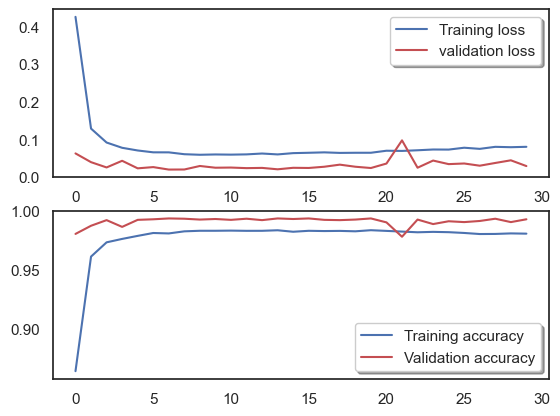

In [44]:
# Plot the loss and accuracy curves for training and validation 
#history객체는 훈련 중의 손실과 정확도 값을 포함
fig, ax = plt.subplots(2,1) #2개의 서브플롯을 가진 그림을 생성
ax[0].plot(history.history['loss'], color='b', label="Training loss") #훈련 손실은 파란색으로 플롯
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0]) #검증 손실은 빨간색
legend = ax[0].legend(loc='best', shadow=True) #legend는 범례 추가 / loc="best"는 그래프의 데이터에 가장 적게 가려지는 자동 위치
 
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy") #acc -> accuracy / val_acc -> val_accuracy
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

##history["loss"]가 아닌, history.history["loss"]인 이유. history["loss"]가 dictornary형태여서

4-2 Confusion Matrix
-Confusion Matrix 분류 문제에서 모델의 성능을 평가. 
1.True Positive(TP): 양성 클래스를 양성으로 정확하게 예측한 경우의 수
2.False Positive(TP):음성 클래스를 양성으로 잘못 예측한 경우의 수
3.True Negative(TN): 음성 클래스를 음성으로 정확하게 예측한 경우의 수
4.False Negative(FN):양성 클래스를 음성으로 잘못 예측한 경우의 수

정확도(Accuracy) = TP + TN / TP + FP + TN + FN : 전체 예측 중 올바른 예측의 비율
정밀도(Rrecision) = TP / TP+FP : 양성으로 예측된 항목 중 실제로 양성인 항목의 비율
재현율(Recall / Sensitivity): TP / TP + FN 실제 양성 항목 중 모델이 양성으로 예측한 항목의 비율
F1score: 2 * precision * recall / precision + recall 정밀도와 재현율의 조화 평균

##혼동 행렬 이부분은 공부가 더 많이 필요하다고 생각

132/132 [==============================] - 2s 13ms/step


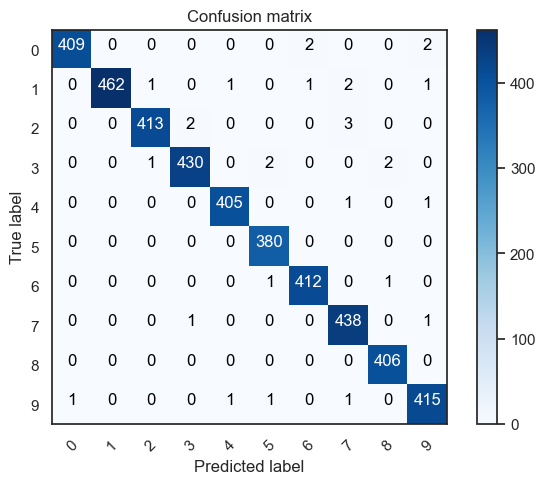

In [48]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val) #모델 예측
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)  #원핫 인코딩으로 변경
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

plot_confusion_matrix 함수 정의 -> 혼동 행렬을 시가화
cm은 혼동 행렬, classes는 클래스의 목록, normalize 매개변수가 true로 설정되면, 혼동 핼렬을 정규화 됌 -> 그래프의 제목과 색상 맵도 설정할 수 있음


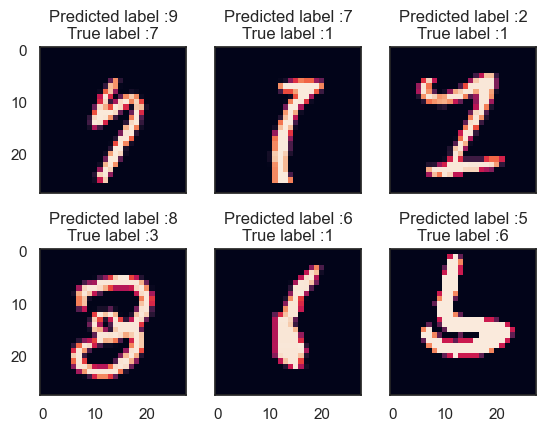

In [49]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0) #실제 데이터와 예측 데이터의 차이가 0이 아닌 경우 true값 배열 만듬 (값이 true / false로 나옴)
#ex) [0, -1, 0, -1, 0, 0...]
#예측값과 실게값이 같으면 0 인데, 값이 0이 나오지 않는다는 것은 error


#오류 데이ㅓ터 추출 (예측 클래스, 예측 확률, 실제 클래스, 이미지 데이터 추출)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

#error 데이터 시각화 부분
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0 #잘못된 변수 추적하는 카운터 변수
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True) #sharex, sharey 생성된 서브플롯들이 x,y축의 눈금과 스케일 공유
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1 #잘못된 부분 카운터

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1) #잘못 분류된 각 예제의 예측 레이블의 확률

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1)) #실제 잘못 분류 확률

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors #예측 레비을의 확률과 실제 레이블의 확률 간의 차이

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors) #확률 차이를 기준으로 오류 정렬

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:] #상위 6개 오류 찾기

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

#human error로 인해서 발생하는 문제들도 많은 
3번째의 경우 2로 보이지만, 라벨링된 데이터는 1임

In [50]:
#predict results
results = model.predict(test) #cnn,  relu, 위에서 계속 학습한 model

#select the indix with the maximum probability
results = np.argmax(results, axis = 1) #가장 높은 확률을 가진 클래스의 인덱스를 찾음
#np.argmax 주어진 배열에서 최대값은 인덱스를 반환 :인덱스 순서) (각 행에서)
#확률상 제일 높다고 판단하는 값을 results에 값 저장


#series로 변환(1차원 배열로 변경 / 인덱스와 값)
results = pd.Series(results, name="Label") #모델이 예측한 값을 보여줌
#새로운 "label"이라는 열을 생성

875/875 [==============================] - 12s 13ms/step


In [51]:
print(results)

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64


In [55]:
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), results], axis = 1)

submission.to_csv("cnn_mnist_datagen.csv", index=False)